<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/student_pgm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The (simplified) student Bayes net

This model is from https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/2.%20Bayesian%20Networks.ipynb

In [3]:
!pip install -q causalgraphicalmodels
!pip install -q pgmpy
!pip install superimport

!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pgmpy_utils.py
#import pyprobml_utils as pml
import pgmpy_utils as pgm

  Created wheel for superimport: filename=superimport-0.3.4-py3-none-any.whl size=5886 sha256=babb8377ea4a6bf3a4c505363b573cd2be29e13601ed621df7291afcce0a2be3
  Stored in directory: /root/.cache/pip/wheels/6c/66/dc/337052d868002cf3830606ee34d91d1ceff6a67bf8df982c72
Successfully built superimport


In [4]:
from causalgraphicalmodels import CausalGraphicalModel
import pgmpy
import numpy as np
import pandas as pd

# Model



<img src="https://user-images.githubusercontent.com/4632336/118884310-21bec180-b8ab-11eb-81cf-481553c21d8a.png?raw=true">


In [5]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.
#model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])
model = BayesianModel([('Diff', 'Grade'), ('Intel', 'Grade'), ('Grade', 'Letter'), ('Intel', 'SAT')])



/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


## Basic CPDs

In [6]:
# Defining individual CPDs.
cpd_d = TabularCPD(variable='Diff', variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable='Intel', variable_card=2, values=[[0.7], [0.3]])

# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | diff    | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | intel   | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_0 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(variable='Grade', variable_card=3, 
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['Intel', 'Diff'],
                  evidence_card=[2, 2])

cpd_l = TabularCPD(variable='Letter', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['Grade'],
                   evidence_card=[3])

cpd_s = TabularCPD(variable='SAT', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['Intel'],
                   evidence_card=[2])

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly 
# defined and sum to 1.
model.check_model()

True

In [7]:
print(model.get_cpds('Grade'))

+----------+----------+----------+----------+----------+
| Intel    | Intel(0) | Intel(0) | Intel(1) | Intel(1) |
+----------+----------+----------+----------+----------+
| Diff     | Diff(0)  | Diff(1)  | Diff(0)  | Diff(1)  |
+----------+----------+----------+----------+----------+
| Grade(0) | 0.3      | 0.05     | 0.9      | 0.5      |
+----------+----------+----------+----------+----------+
| Grade(1) | 0.4      | 0.25     | 0.08     | 0.3      |
+----------+----------+----------+----------+----------+
| Grade(2) | 0.3      | 0.7      | 0.02     | 0.2      |
+----------+----------+----------+----------+----------+


## CPDs with names states

In [8]:
# CPDs can also be defined using the state names of the variables. If the state names are not provided
# like in the previous example, pgmpy will automatically assign names as: 0, 1, 2, ....

cpd_d_sn = TabularCPD(variable='Diff', variable_card=2, values=[[0.6], [0.4]], 
                      state_names={'Diff': ['Easy', 'Hard']})
cpd_i_sn = TabularCPD(variable='Intel', variable_card=2, values=[[0.7], [0.3]],
                      state_names={'Intel': ['Dumb', 'Intelligent']})
cpd_g_sn = TabularCPD(variable='Grade', variable_card=3, 
                      values=[[0.3, 0.05, 0.9,  0.5],
                              [0.4, 0.25, 0.08, 0.3],
                              [0.3, 0.7,  0.02, 0.2]],
                      evidence=['Intel', 'Diff'],
                      evidence_card=[2, 2],
                      state_names={'Grade': ['A', 'B', 'C'],
                                   'Intel': ['Dumb', 'Intelligent'],
                                   'Diff': ['Easy', 'Hard']})

cpd_l_sn = TabularCPD(variable='Letter', variable_card=2, 
                      values=[[0.1, 0.4, 0.99],
                              [0.9, 0.6, 0.01]],
                      evidence=['Grade'],
                      evidence_card=[3],
                      state_names={'Letter': ['Bad', 'Good'],
                                   'Grade': ['A', 'B', 'C']})

cpd_s_sn = TabularCPD(variable='SAT', variable_card=2,
                      values=[[0.95, 0.2],
                              [0.05, 0.8]],
                      evidence=['Intel'],
                      evidence_card=[2],
                      state_names={'SAT': ['Bad', 'Good'],
                                   'Intel': ['Dumb', 'Intelligent']})

# These defined CPDs can be added to the model. Since, the model already has CPDs associated to variables, it will
# show warning that pmgpy is now replacing those CPDs with the new ones.
model.add_cpds(cpd_d_sn, cpd_i_sn, cpd_g_sn, cpd_l_sn, cpd_s_sn)
model.check_model()

INFO:root:Replacing existing CPD for Diff
INFO:root:Replacing existing CPD for Intel
INFO:root:Replacing existing CPD for Grade
INFO:root:Replacing existing CPD for Letter
INFO:root:Replacing existing CPD for SAT


True

In [9]:
 #Printing a CPD with it's state names defined.
print(model.get_cpds('Grade'))

+----------+-------------+-----+--------------------+
| Intel    | Intel(Dumb) | ... | Intel(Intelligent) |
+----------+-------------+-----+--------------------+
| Diff     | Diff(Easy)  | ... | Diff(Hard)         |
+----------+-------------+-----+--------------------+
| Grade(A) | 0.3         | ... | 0.5                |
+----------+-------------+-----+--------------------+
| Grade(B) | 0.4         | ... | 0.3                |
+----------+-------------+-----+--------------------+
| Grade(C) | 0.3         | ... | 0.2                |
+----------+-------------+-----+--------------------+


In [10]:
for cpd in model.get_cpds():
  print(cpd)

+------------+-----+
| Diff(Easy) | 0.6 |
+------------+-----+
| Diff(Hard) | 0.4 |
+------------+-----+
+--------------------+-----+
| Intel(Dumb)        | 0.7 |
+--------------------+-----+
| Intel(Intelligent) | 0.3 |
+--------------------+-----+
+----------+-------------+-----+--------------------+
| Intel    | Intel(Dumb) | ... | Intel(Intelligent) |
+----------+-------------+-----+--------------------+
| Diff     | Diff(Easy)  | ... | Diff(Hard)         |
+----------+-------------+-----+--------------------+
| Grade(A) | 0.3         | ... | 0.5                |
+----------+-------------+-----+--------------------+
| Grade(B) | 0.4         | ... | 0.3                |
+----------+-------------+-----+--------------------+
| Grade(C) | 0.3         | ... | 0.2                |
+----------+-------------+-----+--------------------+
+--------------+----------+----------+----------+
| Grade        | Grade(A) | Grade(B) | Grade(C) |
+--------------+----------+----------+----------+
| Lett

# Inference

In [11]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Posterior given Grade=C

In [12]:
evidence = {'Grade': 'C'}
postD = infer.query(['Diff'],  evidence=evidence).values
postI = infer.query(['Intel'],  evidence=evidence).values

print('\n')
print('Pr(Difficulty=Hard|Grade=C) = {:0.2f}'.format(postD[1]))
print('Pr(Intelligent=High|Grade=C) = {:0.2f}'.format(postI[1]))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]



Pr(Difficulty=Hard|Grade=C) = 0.63
Pr(Intelligent=High|Grade=C) = 0.08


## Posterior given Grade=C, SAT=Good

In [13]:
evidence = {'Grade': 'C', 'SAT': 'Good'}
postD = infer.query(['Diff'],  evidence=evidence).values
postI = infer.query(['Intel'],  evidence=evidence).values

print('\n')
print('Pr(Difficulty=Hard|Grade=C,SAT=Good) = {:0.2f}'.format(postD[1]))
print('Pr(Intelligent=High|Grade=C,SAT=Good) = {:0.2f}'.format(postI[1]))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]



Pr(Difficulty=Hard|Grade=C,SAT=Good) = 0.76
Pr(Intelligent=High|Grade=C,SAT=Good) = 0.58


# Visualization

## DAG

<class 'graphviz.dot.Digraph'>


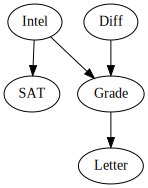

'student_pgm.pdf'

In [14]:
model2 = CausalGraphicalModel(nodes = model.nodes(), edges=model.edges())

dot = model2.draw()
print(type(dot))
display(dot)
dot.render(filename='student_pgm', format='pdf')
# creates student_pgm (a text file of the graph) and student_pgm.pdf

In [15]:
from google.colab import files
#files.view('student_pgm') # open text file

<IPython.core.display.Javascript object>

## CPTs

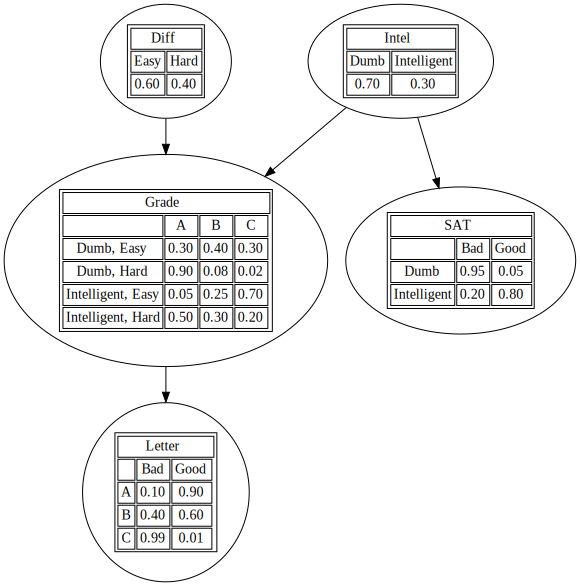

'student_pgm_with_cpt.pdf'

In [16]:
dot = pgm.visualize_model(model)
display(dot)
dot.render('student_pgm_with_cpt', format='pdf')


## Marginals

In [17]:

evidence = {'Grade': 'C'}
marginals = pgm.get_marginals(model, evidence)
print(marginals)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'Diff': array([0.37070938, 0.62929062]), 'Grade': array([0., 0., 1.]), 'Intel': array([0.92105263, 0.07894737]), 'Letter': array([0.99, 0.01]), 'SAT': array([0.89078947, 0.10921053])}


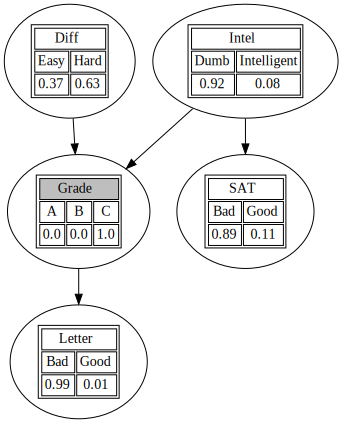

'student_pgm_marginals_given_grade.pdf'

In [18]:
dot = pgm.visualize_marginals(model, evidence, marginals)
display(dot)
dot.render('student_pgm_marginals_given_grade', format='pdf')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Diff': array([0.24044002, 0.75955998]), 'Grade': array([0., 0., 1.]), 'Intel': array([0.42168675, 0.57831325]), 'Letter': array([0.99, 0.01]), 'SAT': array([0., 1.])}


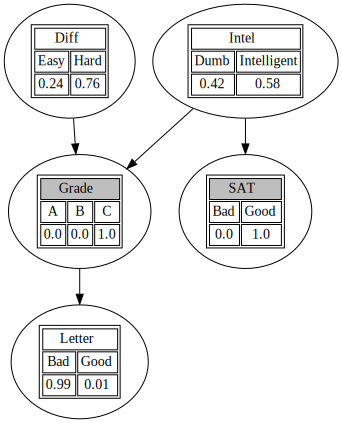

'student_pgm_marginals_given_grade_sat.pdf'

In [19]:

evidence = {'Grade': 'C', 'SAT': 'Good'}
marginals = pgm.get_marginals(model, evidence)
print(marginals)

dot = pgm.visualize_marginals(model, evidence, marginals)
display(dot)
dot.render('student_pgm_marginals_given_grade_sat', format='pdf')